In [1]:
%load_ext autoreload
%autoreload 2
import logging
import sys
import time
from dataclasses import dataclass
from enum import Enum

from autoscript_sdb_microscope_client.structures import AdornedImage, StagePosition, ManipulatorPosition
from liftout.fibsem.sample import Sample, Lamella, AutoLiftoutState, AutoLiftoutStage

### New Sample Data Structure
Prototyping for the new sample dataclass, and filesystem structures


In [2]:
import random
import os
from pprint import pprint

from liftout.fibsem.sample import create_experiment, load_experiment
from pathlib import Path

sample_name = "test_sample2"
sample = create_experiment(experiment_name=sample_name, path="")

for i in range(1, random.randint(6, 8)):

    lamella = Lamella(path=sample.path, number=i)
    lamella.lamella_coordinates = StagePosition(i, i, i, i, i)
    lamella.landing_coordinates = StagePosition(i, i, i, i, i)

    import random
    lamella.current_state.stage   = random.choice([stage for stage in AutoLiftoutStage]) 

    for j in range(random.randint(1, 6)):
        lamella.history.append(lamella.current_state)

    sample.positions[lamella._number] = lamella

pprint(sample)
pprint(sample.positions)

# save to file
sample.save()

# load from file
sample2 = load_experiment(sample.path)

# validation
assert sample.path == sample2.path
for i in sample.positions:
    assert sample.path[i] == sample2.path[i]
    assert sample.positions[i].lamella_coordinates == sample2.positions[i].lamella_coordinates
    assert sample.positions[i].landing_coordinates == sample2.positions[i].landing_coordinates
    assert sample.positions[i]._id == sample2.positions[i]._id
    assert sample.positions[i]._petname == sample2.positions[i]._petname
    assert sample.positions[i].current_state == sample2.positions[i].current_state
    assert sample.positions[i].history == sample2.positions[i].history
    print(f"lamella {i} passed.")

# updates to dictionarys follow reference, not sure about others

# sample.save()


Sample: 
        Path: test_sample2_2022-07-22.04-31-54PM
        State: None
        Lamella: 7
        
{1: 
        Lamella 1 (01-witty-mako). 
        Lamella Coordinates: StagePosition(x=1, y=1, z=1, t=1, r=1), 
        Landing Coordinates: StagePosition(x=1, y=1, z=1, t=1, r=1), 
        Current Stage: AutoLiftoutStage.Failure,
        Last Completed: AutoLiftoutStage.Setup
        History: 2 stages completed (['Failure', 'Failure']).
        ,
 2: 
        Lamella 2 (02-valid-tapir). 
        Lamella Coordinates: StagePosition(x=2, y=2, z=2, t=2, r=2), 
        Landing Coordinates: StagePosition(x=2, y=2, z=2, t=2, r=2), 
        Current Stage: AutoLiftoutStage.Initialisation,
        Last Completed: AutoLiftoutStage.Setup
        History: 4 stages completed (['Initialisation', 'Initialisation', 'Initialisation', 'Initialisation']).
        ,
 3: 
        Lamella 3 (03-more-troll). 
        Lamella Coordinates: StagePosition(x=3, y=3, z=3, t=3, r=3), 
        Landing Coordinates

test_sample2_2022-07-22.04-31-54PM


### New Protocol
- Splitting the protocol into separate files. 
    - load into a single settings, dictionary
    - save protocol into individual files 
    - load protocol individually
    - possibly change to loading experiments

In [143]:
base_path = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout"

from pprint import pprint
from liftout.utils import load_config_v2

system_fname = os.path.join(base_path, "config", "system.yaml")
calibration_fname = os.path.join(base_path, "config", "calibration.yaml")
protocol_fname = os.path.join(base_path, "protocol", "protocol.yaml")

settings = load_config_v2(
    system_fname, 
    calibration_fname, 
    protocol_fname
)

pprint(settings)


def update_protocol(settings: dict, step: str, fname: Path) -> None:

    print("step: ", step)
    pprint(settings["protocol"][step])
    print("fname: ", fname)
    print("-"*50)


# from liftout.fibsem.milling import get_milling_protocol_stages
# protocol_stages = get_milling_protocol_stages(settings, "lamella")

# pprint(protocol_stages)

for k in settings["protocol"].keys():
    update_protocol(settings, k, None)


{'calibration': {'calibration': {'drift_correction_hfw_highres': 8e-05,
                                 'eucentric_height_eb': 0.004,
                                 'eucentric_height_ib': 0.0165,
                                 'eucentric_height_tolerance': 0.0005,
                                 'eucentric_hfw_highres': 0.0002,
                                 'eucentric_hfw_lowres': 0.0009,
                                 'eucentric_hfw_midres': 0.0004,
                                 'max_eb_hfw': 0.0027,
                                 'max_ib_hfw': 0.0009,
                                 'max_working_distance_eb': 0.006,
                                 'stage_height_limit': 0.0037},
                 'gamma': {'correction': 1.0,
                           'max_gamma': 1.8,
                           'min_gamma': 0.15,
                           'scale_factor': 0.01,
                           'threshold': 46.0},
                 'imaging': {'autocontrast': 1.0,
          

step:  lamella
{'lamella_height': 6e-06,
 'lamella_width': 1.2e-05,
 'milling_current': 7.6e-09,
 'milling_depth': 1.5e-05,
 'protocol_stages': [{'milling_current': 7.6e-09,
                      'offset': 2e-06,
                      'trench_height': 1e-05},
                     {'milling_current': 7.6e-09,
                      'offset': 0.0,
                      'trench_height': 3e-06}],
 'size_ratio': 1.0}
fname:  None
--------------------------------------------------
step:  jcut
{'extra_bit': 8e-06,
 'height': 5e-06,
 'jcut_angle': 6.0,
 'length': 1.2e-05,
 'milling_current': 2e-09,
 'milling_depth': 3e-06,
 'trench_thickness': 1e-06}
fname:  None
--------------------------------------------------
step:  weld
{'depth': 2e-07, 'height': 5e-06, 'rotation': 0.0, 'width': 3e-06}
fname:  None
--------------------------------------------------
step:  sharpen
{'bias': 2.5e-07,
 'depth': 8e-06,
 'height': 2.5e-06,
 'hfw': 0.00015,
 'milling_current': 7.6e-09,
 'needle_angle': 40.0,
 'ti

,label,p1.type,p1.x,p1.y,p2.type,p2.x,p2.y
0,2022-07-26.01-11-52PM_label,NeedleTip,0.569897,0.523096,LamellaCentre,0.332863,0.330617
1,2022-07-26.01-12-36PM_label,NeedleTip,0.279397,0.501709,LamellaCentre,0.332863,0.330617
2,2022-07-26.01-20-17PM_label,NeedleTip,0.254446,0.704882,LamellaCentre,0.459400,0.429530
3,2022-07-26.01-27-23PM_label,NeedleTip,0.281179,0.426856,LamellaCentre,0.461182,0.298537
4,2022-07-26.01-33-13PM_label,NeedleTip,0.238406,0.234377,LamellaCentre,0.395240,0.448243


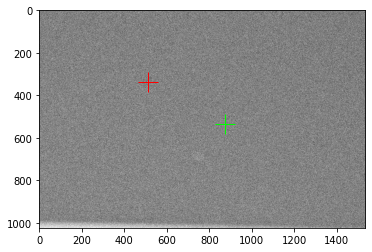

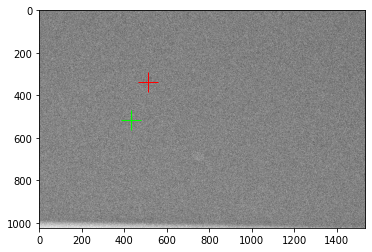

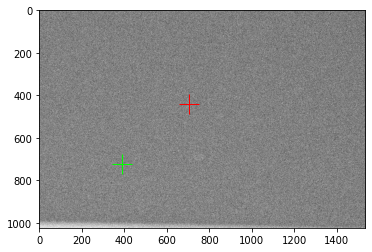

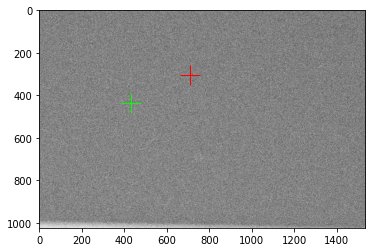

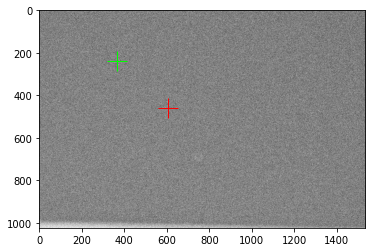

In [53]:
import matplotlib.pyplot as plt
from autoscript_sdb_microscope_client.structures import AdornedImage
import pandas as pd
from liftout.detection.utils import load_detection_result, plot_detection_result
from pathlib import Path


# TODO: aggregate multiple datasets together...

path = r"C:\Users\Admin\Github\autoliftout\tools\test\label\data.csv"
base = os.path.dirname(path)
df = pd.read_csv(path)
display(df)

for idx, row in df.iterrows():
    
    det_result = load_detection_result(base, row)
    fig = plot_detection_result(det_result)

    plt.show()
    plt.close()

#### CRossCorrelation Refactor

In [52]:
from autoscript_sdb_microscope_client.structures import AdornedImage
from liftout.fibsem import calibration, acquire
from liftout.fibsem import utils as fibsem_utils
import glob
import os
import random
import matplotlib.pyplot as plt

from pprint import pprint
path = r"C:\Users\Admin\Github\autoliftout\tools\test\label"
filenames = glob.glob(os.path.join(path, "*.tif"))



In [26]:
microscope, settings, image_settings = fibsem_utils.quick_setup()

2022-07-26 13:44:06,967 — root — INFO — connect_to_microscope:14 — Microscope client connecting to [10.0.0.1]
2022-07-26 13:44:06,975 — root — INFO — connect_to_microscope:17 — Microscope client connected to [10.0.0.1]


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


2022-07-26 13:44:20,256 — root — INFO — autocontrast:52 — automatically adjusting contrast...
2022-07-26 13:44:20,893 — root — INFO — acquire_image:177 — acquiring new ELECTRON image.
2022-07-26 13:44:23,061 — root — INFO — gamma_correction:78 — GAMMA_CORRECTION | Electron | 2.815 | 1.000
2022-07-26 13:44:23,076 — root — INFO — autocontrast:52 — automatically adjusting contrast...
2022-07-26 13:44:27,438 — root — INFO — acquire_image:177 — acquiring new ION image.
2022-07-26 13:44:29,345 — root — INFO — gamma_correction:78 — GAMMA_CORRECTION | Ion | -72.468 | 0.275


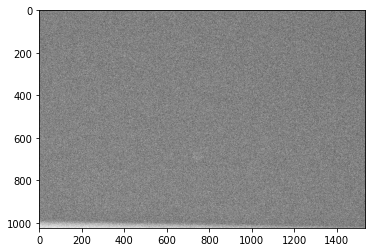

In [27]:
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings)


plt.imshow(eb_image.data, cmap="gray")
plt.show()



In [51]:
eb_image.metadata.scan_settings.scan_size

from liftout import utils
from liftout.fibsem.acquire import ImageSettings, BeamType


pprint(image_settings)
image_settings = calibration.match_image_settings(ib_image, image_settings)

pprint(image_settings)




ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, autocontrast=1.0, beam_type=<BeamType.ELECTRON: 1>, save=False, label='2022-07-26.01-44-06PM', gamma=GammaSettings(enabled=1.0, min_gamma=0.15, max_gamma=1.8, scale_factor=0.01, threshold=46.0), save_path='c:\\Users\\Admin\\Github\\autoliftout\\liftout\\tools\\auto\\tools/test')
ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw='1024x1536', autocontrast=1.0, beam_type=<BeamType.ION: 2>, save=True, label='2022-07-26.02-30-17PM', gamma=GammaSettings(enabled=1.0, min_gamma=0.15, max_gamma=1.8, scale_factor=0.01, threshold=46.0), save_path='c:\\Users\\Admin\\Github\\autoliftout\\liftout\\tools\\auto\\tools/test')


### State Testing


In [61]:
%load_ext autoreload 
%autoreload 2
from liftout import autoliftout
from liftout.fibsem import utils as fibsem_utils
from liftout.fibsem.sample import Sample, Lamella, create_experiment

microscope, settings, image_settings = fibsem_utils.quick_setup()

print(image_settings.save_path)

sample = create_experiment("my_experiment", image_settings.save_path)

for no in range(1, 3):
    lamella = Lamella(sample.path, no)
    sample.positions[lamella._number] = lamella

from pprint import pprint 


2022-07-26 16:15:48,703 — root — INFO — connect_to_microscope:14 — Microscope client connecting to [10.0.0.1]
2022-07-26 16:15:48,750 — root — INFO — connect_to_microscope:17 — Microscope client connected to [10.0.0.1]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]
c:\Users\Admin\Github\autoliftout\liftout\tools\auto\tools/test


In [64]:
key = list(sample.positions.keys())[0]
lamella = sample.positions[key]
sample = autoliftout.end_of_stage_update(microscope, sample, lamella)

2022-07-26 16:17:42,638 — root — INFO — end_of_stage_update:920 — 01-picked-drake | AutoLiftoutStage.Setup | FINISHED


[AutoLiftoutState(stage=<AutoLiftoutStage.Setup: 0>, microscope_state=MicroscopeState(timestamp=1658816262.607262, absolute_position=StagePosition(x=-0.0032375833, y=0.0039354167, z=0.025705601, t=-1.1707575e-06, r=0.87268378, coordinate_system=Raw), last_completed_stage=<AutoLiftoutStage.Setup: 0>, eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.0060001519009892125, beam_current=4e-10, hfw=4.144482370817515e-05, resolution='1536x1024', dwell_time=1e-06, stigmation=Point(x=0.0056154404, y=0.058047261)), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.016638629968149698, beam_current=2e-11, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=Point(x=0, y=0))), start_timestamp=None, end_timestamp=1658816262.623797),
 AutoLiftoutState(stage=<AutoLiftoutStage.Setup: 0>, microscope_state=MicroscopeState(timestamp=1658816262.607262, absolute_position=StagePosition(x=-0.0032375833, y=0.0039354167, z=0.025705601, t=-1.1707575